In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

In [2]:
cd Geolife\ Trajectories\ 1.3

/home/me/Documents/cse523/Geolife Trajectories 1.3


In [3]:
x = pd.read_csv('Data/000/Trajectory/20081023025304.plt', skiprows=6, header=None)

In [14]:
x.head()

,0,1,2,3,4,5,6
0,39.984702,116.318417,0,492,39744.120185,2008-10-23,02:53:04
1,39.984683,116.318450,0,492,39744.120255,2008-10-23,02:53:10
2,39.984686,116.318417,0,492,39744.120313,2008-10-23,02:53:15
3,39.984688,116.318385,0,492,39744.120370,2008-10-23,02:53:20
4,39.984655,116.318263,0,492,39744.120428,2008-10-23,02:53:25


In [18]:
point2dist(x.iloc[0, :2], (x.iloc[1, :2], x.iloc[2, :2]))

1.5934291306047993e-05

In [23]:
## distance functions
def point2dist(point, line):
    return np.linalg.norm(np.cross(point-line[0], line[1]-line[0]))/np.linalg.norm(line[1]-line[0])

def vertial_distance(x, y):
    dist_end1 = point2dist(x[0], y)
    dist_end2 = point2dist(x[1], y)
    return (dist_end1**2 + dist_end2**2)/(dist_end1+dist_end2)

def parallel_distance(x, y):
    return np.max(np.abs(x[0]-y[0]), np.abs(x[1]-y[1]))

def angular_distance(x, y):
    dist = np.cross(x[1]-x[0], y[1]-y[0])/np.linalg.norm(y[1]-y[0])
    if dist < 0:
        return np.linalg.norm(x[1]-x[0])
    else:
        return dist

In [25]:
# MDL cost
def mdl(model, data):
    # L(H) model cost
    lh = np.norm(model[0]-model[1])
    # L(D|H)
    ldh = 0
    for i in range(len(data)-1):
        ldh = ldh + vertical_distance(model, (data[i], data[i+1]))+angular_distance(model, (data[i], data[i+1]))
    return lh + ldh

In [ ]:
## MDL partition algorithm
def mdl_partition(path):
    partition_set = set(path[0])
    start_index = 0
    length = 1
    while start_index+length < len(path):
        curr_index = start_index + length
        # MDL cost if curr_index is included as a characteristic point
        mdlparcost=mdl((path[start_index], path[curr_index]), path[start_index:curr_index+1])
        mdlnoparcost=mdl((path[start_index], path[len(path)-1]), path[start_index:curr_index+1])
        if mdlparcost > mdlnoparcost:
            

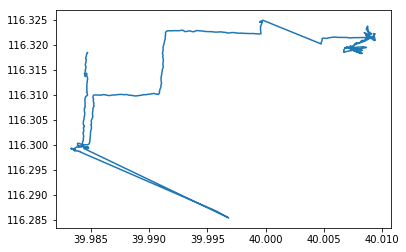

In [7]:
plt.plot(x[0], x[1])